### Optimización de Rutas para Cajeros

### 1.Configuración Inicial

In [59]:
# Importación de librerías

# Librerías estándar
import os
import json
import math
import random
import warnings
from datetime import datetime, timedelta

# Manejo de datos
import pandas as pd
import numpy as np
import geopandas as gpd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, AntPath
import geopandas as gpd
from folium.plugins import AntPath

# Bases de datos y entorno
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Análisis de redes y optimización de rutas
import networkx as nx
import osmnx as ox
from scipy.spatial.distance import cdist
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Configuración para visualización
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

# Conexión a la base de datos

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener los valores del archivo .env
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

# Cadena de conexión para SQLAlchemy
conn_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(conn_string)

print(f"Conectado a: {db_name} en {db_host}")


Conectado a: atm_optimization en localhost


### 2.Carga de datos

#### Carga de la información requerida

In [ ]:
# Cargar datos de cajeros
try:
    query_atms = """
    SELECT id, name, 
           ST_X(location::geometry) as longitude, 
           ST_Y(location::geometry) as latitude,
           capacity, cash_type, location_type, 
           min_threshold, max_capacity
    FROM atms;
    """
    atms_df = pd.read_sql(query_atms, engine)
    print(f"Datos de cajeros cargados: {len(atms_df)} registros")
    
    if len(atms_df) > 0:
        display(atms_df.head())
except Exception as e:
    print(f"Error al cargar cajeros: {e}")
    # Si no se pueden cargar los datos, crear un DataFrame de ejemplo
    atms_df = pd.DataFrame({
        'id': [f'ATM00{i}' for i in range(1, 11)],
        'name': [f'Cajero {i}' for i in range(1, 11)],
        'longitude': [-74.0457 - 0.01*i for i in range(10)],
        'latitude': [4.6486 + 0.01*i for i in range(10)],
        'capacity': [80000000 + 10000000*i for i in range(10)],
        'cash_type': ['MULTIPROPÓSITO' if i % 2 == 0 else 'DISPENSADOR' for i in range(10)],
        'location_type': ['MALL', 'TRANSPORT', 'UNIVERSITY'] * 3 + ['MALL'],
        'min_threshold': [10000000 + 1000000*i for i in range(10)],
        'max_capacity': [100000000 + 10000000*i for i in range(10)]
    })
    print("Usando datos de cajeros de ejemplo")

# Cargar datos de transportadoras
try:
    query_carriers = """
    SELECT id, name, 
           ST_X(base_location::geometry) as base_longitude, 
           ST_Y(base_location::geometry) as base_latitude,
           capacity, vehicles, service_area
    FROM carriers;
    """
    carriers_df = pd.read_sql(query_carriers, engine)
    print(f"Datos de transportadoras cargados: {len(carriers_df)} registros")
    
    if len(carriers_df) > 0:
        display(carriers_df.head())
except Exception as e:
    print(f"Error al cargar transportadoras: {e}")
    # Si no se pueden cargar los datos, crear un DataFrame de ejemplo
    carriers_df = pd.DataFrame({
        'id': ['TDV001', 'TDV002'],
        'name': ['Transportadora Seguridad SA', 'TransValues Ltda'],
        'base_longitude': [-74.0628, -74.1347],
        'base_latitude': [4.6486, 4.6212],
        'capacity': [500000000, 700000000],
        'vehicles': [10, 15],
        'service_area': ['NORTE', 'SUR']
    })
    print("Usando datos de transportadoras de ejemplo")

# Cargar datos de restricciones
try:
    query_restrictions = """
    SELECT atm_id, day_of_week, open_time, close_time, restock_allowed
    FROM restrictions;
    """
    restrictions_df = pd.read_sql(query_restrictions, engine)
    print(f"Datos de restricciones cargados: {len(restrictions_df)} registros")
    
    if len(restrictions_df) > 0:
        display(restrictions_df.head())
except Exception as e:
    print(f"Error al cargar restricciones: {e}")
    restrictions_df = pd.DataFrame()
    print("No se cargaron datos de restricciones")

#### Simulación de predicciones de demanda

In [35]:
# Función para simular predicciones de demanda (versión corregida)
def simulate_demand_predictions(atms_df, days=7):
    """
    Simula predicciones de demanda para los cajeros, asegurando que haya
    algunos con prioridad alta y media para la demo.
    
    Args:
        atms_df: DataFrame con información de cajeros
        days: Número de días para los que se generarán predicciones
        
    Returns:
        DataFrame con predicciones de demanda
    """
    predictions = []
    
    # Fecha actual
    current_date = datetime.now()
    
    # Para cada cajero, generar predicciones
    for idx, atm in atms_df.iterrows():
        # Capacidad base y umbral
        capacity = atm['capacity']
        threshold = atm['min_threshold']
        
        # MODIFICACIÓN: Ajustar la simulación para garantizar variedad de prioridades
        # Para fines de demo, asignar manualmente algunos cajeros a prioridades altas
        if idx % 5 == 0:  # 20% de cajeros con prioridad alta
            priority_factor = 0.8  # Consumo muy alto (prioridad 3)
        elif idx % 5 == 1:  # 20% de cajeros con prioridad media
            priority_factor = 0.5  # Consumo medio (prioridad 2)
        else:
            priority_factor = 0.2  # Consumo bajo (prioridad 1)
            
        # Media diaria aproximada (ajustada para asegurar diferentes prioridades)
        daily_mean = capacity * priority_factor * random.uniform(0.05, 0.15)
        
        # Generar predicciones para cada día
        for day in range(days):
            date = current_date + timedelta(days=day)
            
            # Factor del día de la semana (más alto para viernes y sábado)
            day_factor = 1.3 if date.weekday() in [4, 5] else 1.0
            
            # Factor de quincena (más alto para días 15 y 30)
            quincenal_factor = 1.5 if date.day in [15, 30] else 1.0
            
            # Predicción con algo de ruido aleatorio
            prediction = daily_mean * day_factor * quincenal_factor * random.uniform(0.9, 1.1)
            
            # Calcular capacidad restante después de consumo
            remaining_capacity = capacity - prediction
            
            # Días hasta agotamiento basado en predicción y umbral
            if prediction > 0:
                days_until_empty = max(0, (remaining_capacity - threshold) / prediction)
            else:
                days_until_empty = float('inf')
            
            # Prioridad inversa a días hasta agotamiento (más urgente = mayor prioridad)
            if days_until_empty <= 1:
                priority = 3  # Alta (requiere atención inmediata)
            elif days_until_empty <= 3:
                priority = 2  # Media
            else:
                priority = 1  # Baja
                
            # MODIFICACIÓN: Para primer día, forzar algunas prioridades para la demo
            if day == 0:
                if idx % 5 == 0:
                    priority = 3
                    days_until_empty = 0.5
                elif idx % 5 == 1:
                    priority = 2
                    days_until_empty = 2.0
            
            # Añadir a la lista de predicciones
            predictions.append({
                'atm_id': atm['id'],
                'date': date.strftime('%Y-%m-%d'),
                'predicted_demand': prediction,
                'current_capacity': capacity,
                'days_until_empty': days_until_empty,
                'priority': priority,
                'restock_amount': max(0, atm['max_capacity'] - (capacity - prediction))
            })
            
            # Actualizar capacidad para el siguiente día
            capacity = max(0, capacity - prediction)
    
    # Convertir a DataFrame
    predictions_df = pd.DataFrame(predictions)
    
    # Verificar que hay suficientes cajeros con prioridades altas
    day_one = predictions_df[predictions_df['date'] == current_date.strftime('%Y-%m-%d')]
    high_priority = day_one[day_one['priority'] >= 2]
    
    print(f"Cajeros generados para hoy: {len(day_one)}")
    print(f"Cajeros con prioridad alta/media: {len(high_priority)}")
    
    return predictions_df

# Generar predicciones simuladas
demand_predictions = simulate_demand_predictions(atms_df)
print(f"Predicciones simuladas generadas: {len(demand_predictions)} registros")
display(demand_predictions.head(10))

Cajeros generados para hoy: 100
Cajeros con prioridad alta/media: 40
Predicciones simuladas generadas: 700 registros


,atm_id,date,predicted_demand,current_capacity,days_until_empty,priority,restock_amount
0,ATM001,2025-03-21,5.585156e+06,8.884252e+07,0.500000,3,2.335366e+07
1,ATM001,2025-03-22,5.191512e+06,8.325737e+07,12.470255,1,2.854517e+07
2,ATM001,2025-03-23,3.735755e+06,7.806585e+07,16.329692,1,3.228093e+07
3,ATM001,2025-03-24,4.245328e+06,7.433010e+07,13.369613,1,3.652625e+07
4,ATM001,2025-03-25,4.283406e+06,7.008477e+07,12.250762,1,4.080966e+07
5,ATM001,2025-03-26,4.291796e+06,6.580137e+07,11.226812,1,4.510146e+07
6,ATM001,2025-03-27,3.713275e+06,6.150957e+07,11.975930,1,4.881473e+07
7,ATM002,2025-03-21,4.903887e+06,8.022744e+07,2.000000,2,2.094937e+07
8,ATM002,2025-03-22,4.366780e+06,7.532355e+07,13.493387,1,2.531615e+07
9,ATM002,2025-03-23,3.567642e+06,7.095677e+07,15.515856,1,2.888380e+07


### 3.Análisis de necesidades de reabastecimiento

Predicciones para hoy (2025-03-21): 100 cajeros


,atm_id,date,predicted_demand,current_capacity,days_until_empty,priority,restock_amount
0,ATM001,2025-03-21,5.585156e+06,88842521.0,0.500000,3,2.335366e+07
35,ATM006,2025-03-21,1.738209e+07,118509438.0,0.500000,3,4.108398e+07
70,ATM011,2025-03-21,7.026301e+06,81186790.0,0.500000,3,2.326366e+07
105,ATM016,2025-03-21,6.515742e+06,121887116.0,0.500000,3,3.089317e+07
140,ATM021,2025-03-21,1.222197e+07,91097203.0,0.500000,3,3.044141e+07
...,...,...,...,...,...,...,...
511,ATM074,2025-03-21,1.071695e+06,73642807.0,57.408778,1,1.580026e+07
266,ATM039,2025-03-21,1.091068e+06,76355991.0,58.485392,1,1.636227e+07
301,ATM044,2025-03-21,1.824552e+06,130477197.0,59.785110,1,2.791999e+07
581,ATM084,2025-03-21,9.832805e+05,71142633.0,60.499478,1,1.521181e+07


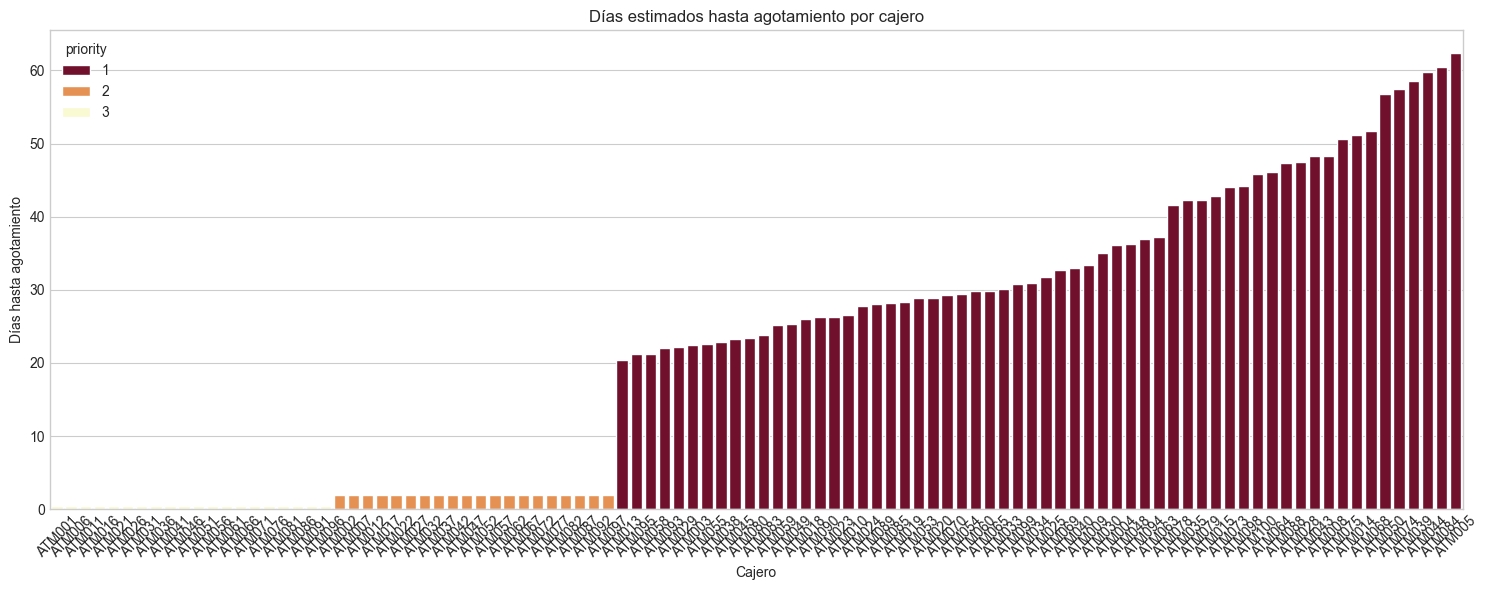

In [36]:
# Filtrar predicciones para el día actual
current_date = datetime.now().strftime('%Y-%m-%d')
todays_predictions = demand_predictions[demand_predictions['date'] == current_date].copy()

# Ordenar por prioridad (descendente) y días hasta agotamiento (ascendente)
todays_predictions = todays_predictions.sort_values(['priority', 'days_until_empty'], 
                                                  ascending=[False, True])

print(f"Predicciones para hoy ({current_date}): {len(todays_predictions)} cajeros")
display(todays_predictions)

# Visualizar gráficamente el estado y prioridades
plt.figure(figsize=(15, 6))
sns.barplot(x='atm_id', y='days_until_empty', hue='priority', 
           data=todays_predictions, palette='YlOrRd_r')
plt.title('Días estimados hasta agotamiento por cajero')
plt.xlabel('Cajero')
plt.ylabel('Días hasta agotamiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # Visualizar la distribución de prioridades
# plt.figure(figsize=(10, 6))
# priority_counts = todays_predictions['priority'].value_counts().to_dict()
# priority_counts_fixed = {
#     1: priority_counts.get(1, 0),
#     2: priority_counts.get(2, 0),
#     3: priority_counts.get(3, 0)
# }
# labels = [
#     f"Baja ({priority_counts_fixed[1]})",
#     f"Media ({priority_counts_fixed[2]})",
#     f"Alta ({priority_counts_fixed[3]})"
# ]
# colors = ['green', 'orange', 'red']
# plt.pie(priority_counts_fixed.values(), labels=labels, autopct='%1.1f%%', colors=colors)
# plt.title('Distribución de prioridades de reabastecimiento')
# plt.axis('equal')
# plt.show()

### 4.Preparación de datos para optimización de rutas

In [37]:
# Seleccionar cajeros que requieren reabastecimiento inmediato (prioridad alta o media)
atms_to_restock = todays_predictions[todays_predictions['priority'] >= 1].copy()

# Unir con datos de ubicación de cajeros
atms_to_restock = pd.merge(
    atms_to_restock,
    atms_df[['id', 'name', 'latitude', 'longitude', 'location_type']],
    left_on='atm_id',
    right_on='id'
)

print(f"Cajeros que requieren reabastecimiento hoy: {len(atms_to_restock)}")
display(atms_to_restock[['atm_id', 'name', 'priority', 'days_until_empty', 'restock_amount']])

# Visualizar cajeros a reabastecer en un mapa
def create_atm_map(atms_df, atms_to_restock, carriers_df):
    """
    Crea un mapa interactivo mostrando cajeros y transportadoras.
    
    Args:
        atms_df: DataFrame con todos los cajeros
        atms_to_restock: DataFrame con cajeros que requieren reabastecimiento
        carriers_df: DataFrame con transportadoras
        
    Returns:
        Mapa de Folium
    """
    # Crear mapa centrado en el promedio de coordenadas
    center_lat = atms_df['latitude'].mean()
    center_lon = atms_df['longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Añadir todos los cajeros (gris)
    for _, row in atms_df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color='gray',
            fill=True,
            fill_opacity=0.5,
            popup=f"{row['name']} (ID: {row['id']})"
        ).add_to(m)
    
    # Añadir cajeros que requieren reabastecimiento con colores según prioridad
    for _, row in atms_to_restock.iterrows():
        # Color según prioridad
        if row['priority'] == 3:
            color = 'red'
        elif row['priority'] == 2:
            color = 'orange'
        else:
            color = 'green'
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"""
            <b>{row['name']}</b><br>
            ID: {row['atm_id']}<br>
            Prioridad: {row['priority']}<br>
            Días hasta agotamiento: {row['days_until_empty']:.1f}
            """,
            icon=folium.Icon(color=color)
        ).add_to(m)
    
    # Añadir transportadoras
    for _, row in carriers_df.iterrows():
        folium.Marker(
            location=[row['base_latitude'], row['base_longitude']],
            popup=f"""
            <b>{row['name']}</b><br>
            Vehículos: {row['vehicles']}
            """,
            icon=folium.Icon(color='black', icon='truck', prefix='fa')
        ).add_to(m)
    
    return m

# Crear y mostrar mapa
restock_map = create_atm_map(atms_df, atms_to_restock, carriers_df)
restock_map

Cajeros que requieren reabastecimiento hoy: 100


,atm_id,name,priority,days_until_empty,restock_amount
0,ATM001,Cajero Banco Oeste,3,0.500000,2.335366e+07
1,ATM006,Cajero Hospital Este,3,0.500000,4.108398e+07
2,ATM011,Cajero Estación Transmilenio Este,3,0.500000,2.326366e+07
3,ATM016,Cajero Hospital Este,3,0.500000,3.089317e+07
4,ATM021,Cajero Universidad Este,3,0.500000,3.044141e+07
...,...,...,...,...,...
95,ATM074,Cajero Hospital Este,1,57.408778,1.580026e+07
96,ATM039,Cajero Estación Transmilenio Este,1,58.485392,1.636227e+07
97,ATM044,Cajero Estación Transmilenio Este,1,59.785110,2.791999e+07
98,ATM084,Cajero Centro Comercial Norte,1,60.499478,1.521181e+07


### 5.Construcción de la matriz de distancia

In [44]:
# Función para calcular distancia euclidiana entre dos puntos
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia de Haversine entre dos puntos en la Tierra.
    Devuelve la distancia en kilómetros.
    """
    # Radio de la Tierra en km
    R = 6371.0
    
    # Convertir de grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Diferencias
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    # Fórmula de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    return distance

# Construir matriz de distancia
def build_distance_matrix(carrier, atms_to_restock):
    """
    Construye una matriz de distancia entre una transportadora y los cajeros a reabastecer.
    
    Args:
        carrier: Serie con datos de la transportadora
        atms_to_restock: DataFrame con cajeros a reabastecer
        
    Returns:
        Matriz de distancias, lista de nombres de lugares
    """
    # Crear lista con transportadora y cajeros
    locations = []
    
    # Añadir transportadora (primer punto = depósito)
    locations.append({
        'id': carrier['id'],
        'name': carrier['name'],
        'lat': carrier['base_latitude'],
        'lon': carrier['base_longitude'],
        'type': 'carrier'
    })
    
    # Añadir cajeros
    for _, atm in atms_to_restock.iterrows():
        locations.append({
            'id': atm['atm_id'],
            'name': atm['name'],
            'lat': atm['latitude'],
            'lon': atm['longitude'],
            'type': 'atm'
        })
    
    # Construir matriz de distancia
    n = len(locations)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                distance_matrix[i][j] = haversine_distance(
                    locations[i]['lat'], locations[i]['lon'],
                    locations[j]['lat'], locations[j]['lon']
                )
    
    # Lugares (para referencia)
    place_names = [location['name'] for location in locations]
    
    return distance_matrix, locations, place_names

# Seleccionar transportadora para la ruta (en un caso real, podríamos optimizar la asignación)
# Para la demo, usamos la primera transportadora
selected_carrier = carriers_df.iloc[0]
print(f"Transportadora seleccionada: {selected_carrier['name']}")

# Construir matriz de distancia
distance_matrix, locations, place_names = build_distance_matrix(selected_carrier, atms_to_restock)

# print(f"Matriz de distancia creada: {distance_matrix.shape}")
# print("Lugares incluidos:")
# for i, name in enumerate(place_names):
#     print(f"  {i}: {name}")

# Visualizar matriz de distancia
# Añadir esta nueva función
def visualize_distance_matrix(distance_matrix, place_names, max_places=10):
    """
    Visualiza una matriz de distancia de manera legible.
    
    Args:
        distance_matrix: Matriz de distancias
        place_names: Nombres de los lugares
        max_places: Número máximo de lugares a mostrar
    """
    # Si hay muchos lugares, mostrar solo un subconjunto
    if len(place_names) > max_places:
        # Siempre incluir la transportadora (índice 0) y una muestra de cajeros
        indices = [0] + list(range(1, min(max_places, len(place_names))))
        sub_matrix = distance_matrix[indices, :][:, indices]
        sub_names = [place_names[i] for i in indices]
    else:
        sub_matrix = distance_matrix
        sub_names = place_names
    
    # Acortar nombres para mejor visualización
    short_names = []
    for name in sub_names:
        if len(name) > 20:
            short_name = name[:17] + "..."
        else:
            short_name = name
        short_names.append(short_name)
    
    # Crear figura con tamaño adecuado
    plt.figure(figsize=(14, 10))
    
    # Crear mapa de calor con anotaciones más claras
    ax = sns.heatmap(
        sub_matrix, 
        annot=True, 
        fmt=".1f", 
        cmap="YlGnBu",
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    
    # Configurar título y etiquetas
    plt.title("Matriz de distancia (km)", fontsize=14, pad=20)
    plt.xlabel("Destino", fontsize=12, labelpad=10)
    plt.ylabel("Origen", fontsize=12, labelpad=10)
    
    # Configurar etiquetas de ejes con rotación para mejor legibilidad
    plt.xticks(np.arange(len(short_names)) + 0.5, short_names, rotation=45, ha='right', fontsize=9)
    plt.yticks(np.arange(len(short_names)) + 0.5, short_names, rotation=0, fontsize=9)
    
    # Ajustar layout
    plt.tight_layout()
    plt.show()

#visualize_distance_matrix(distance_matrix, place_names)

Transportadora seleccionada: TransValues Ltda


### 6. Optimización de rutas utilizando OR-Tools 

Predicciones para hoy (2025-03-21): 100 cajeros


,atm_id,date,predicted_demand,current_capacity,days_until_empty,priority,restock_amount
0,ATM001,2025-03-21,5.585156e+06,88842521.0,0.500000,3,2.335366e+07
35,ATM006,2025-03-21,1.738209e+07,118509438.0,0.500000,3,4.108398e+07
70,ATM011,2025-03-21,7.026301e+06,81186790.0,0.500000,3,2.326366e+07
105,ATM016,2025-03-21,6.515742e+06,121887116.0,0.500000,3,3.089317e+07
140,ATM021,2025-03-21,1.222197e+07,91097203.0,0.500000,3,3.044141e+07
...,...,...,...,...,...,...,...
511,ATM074,2025-03-21,1.071695e+06,73642807.0,57.408778,1,1.580026e+07
266,ATM039,2025-03-21,1.091068e+06,76355991.0,58.485392,1,1.636227e+07
301,ATM044,2025-03-21,1.824552e+06,130477197.0,59.785110,1,2.791999e+07
581,ATM084,2025-03-21,9.832805e+05,71142633.0,60.499478,1,1.521181e+07


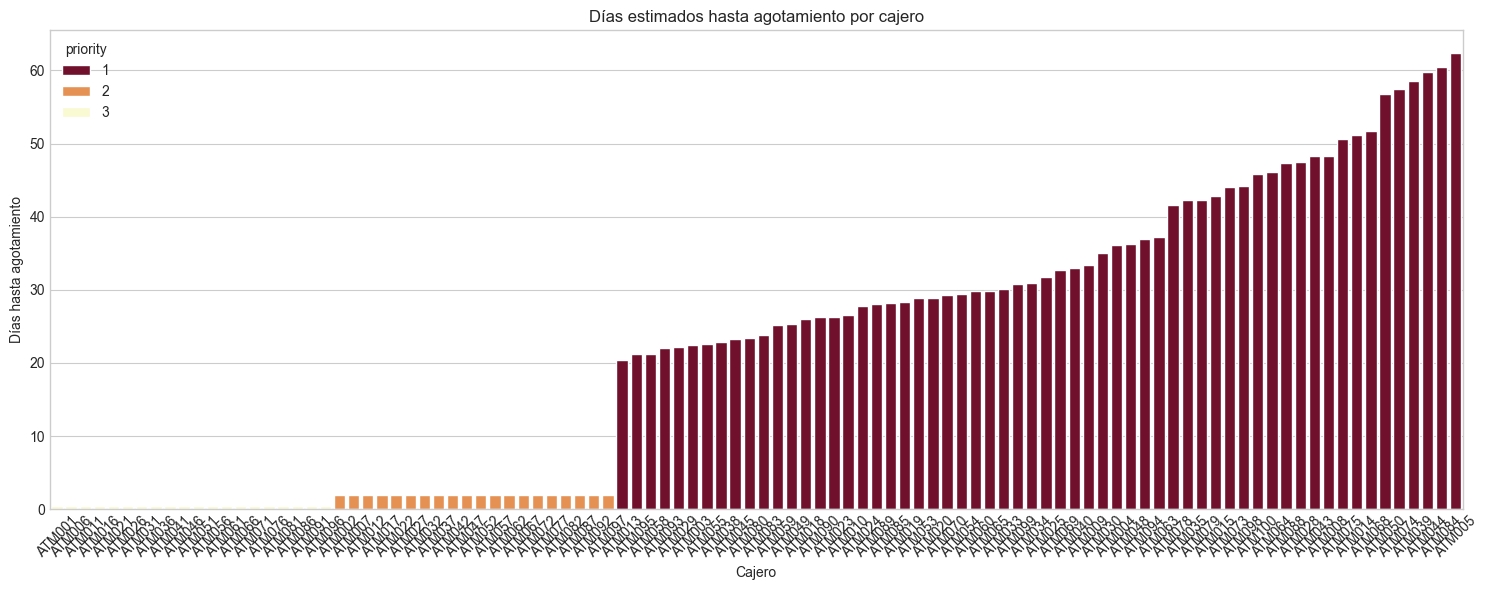

In [ ]:
# Filtrar predicciones para el día actual
current_date = datetime.now().strftime('%Y-%m-%d')
todays_predictions = demand_predictions[demand_predictions['date'] == current_date].copy()

# Ordenar por prioridad (descendente) y días hasta agotamiento (ascendente)
todays_predictions = todays_predictions.sort_values(['priority', 'days_until_empty'], 
                                                  ascending=[False, True])

print(f"Predicciones para hoy ({current_date}): {len(todays_predictions)} cajeros")
display(todays_predictions)

# Visualizar gráficamente el estado y prioridades
plt.figure(figsize=(15, 6))
sns.barplot(x='atm_id', y='days_until_empty', hue='priority', 
           data=todays_predictions, palette='YlOrRd_r')
plt.title('Días estimados hasta agotamiento por cajero')
plt.xlabel('Cajero')
plt.ylabel('Días hasta agotamiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # Visualizar la distribución de prioridades
# plt.figure(figsize=(10, 6))
# priority_counts = todays_predictions['priority'].value_counts().to_dict()
# priority_counts_fixed = {
#     1: priority_counts.get(1, 0),
#     2: priority_counts.get(2, 0),
#     3: priority_counts.get(3, 0)
# }
# labels = [
#     f"Baja ({priority_counts_fixed[1]})",
#     f"Media ({priority_counts_fixed[2]})",
#     f"Alta ({priority_counts_fixed[3]})"
# ]
# colors = ['green', 'orange', 'red']
# plt.pie(priority_counts_fixed.values(), labels=labels, autopct='%1.1f%%', colors=colors)
# plt.title('Distribución de prioridades de reabastecimiento')
# plt.axis('equal')
# plt.show()

Limitando optimización a los 15 cajeros más prioritarios


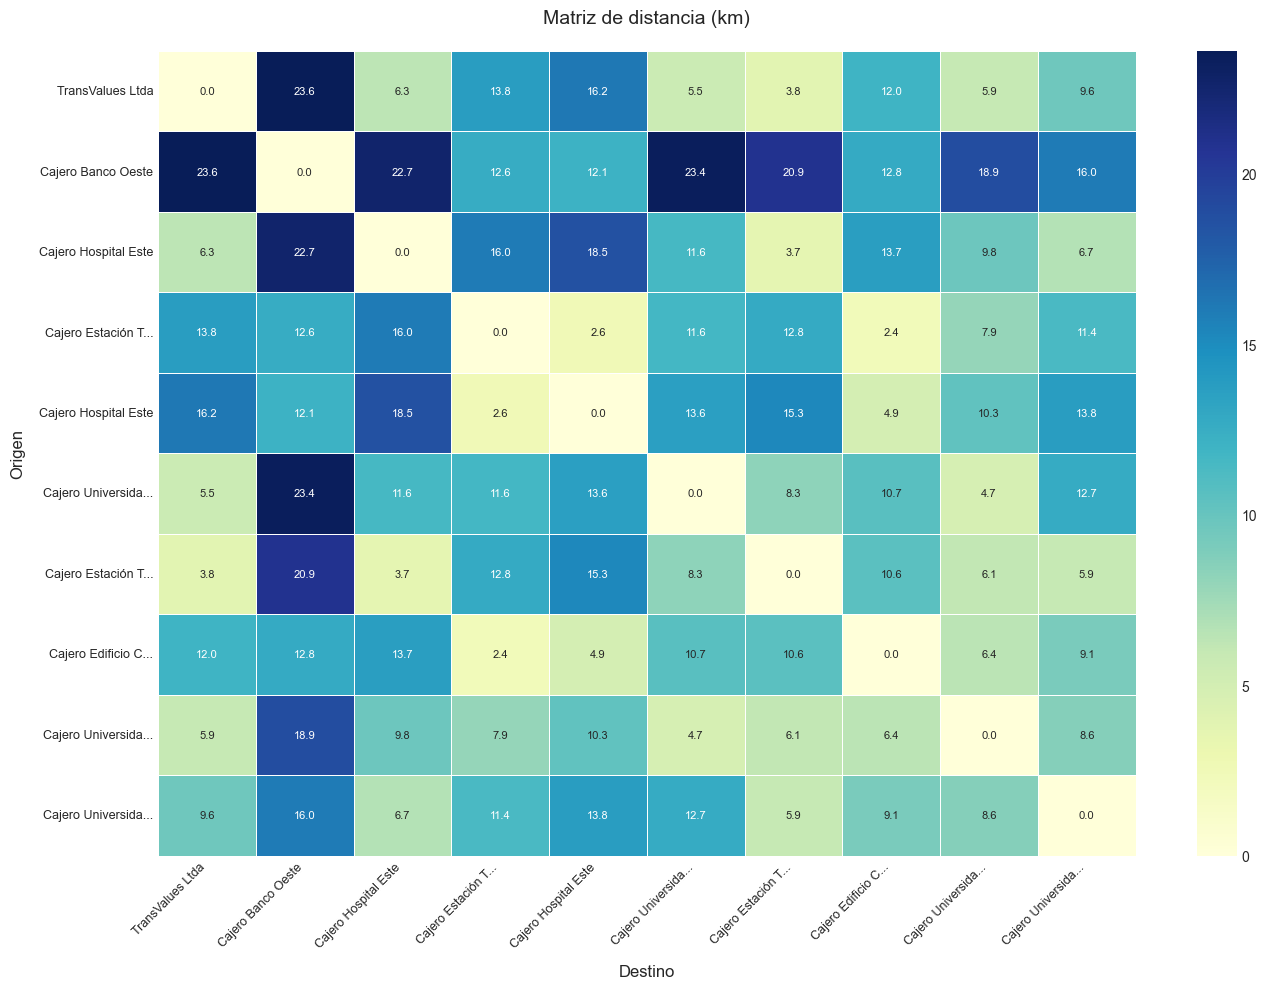

¡Solución encontrada!
Distancia total: 98.10 kilómetros
Ruta para el vehículo 1:
  [Vehículo no utilizado]
Ruta para el vehículo 2:
  TransValues Ltda ->   Cajero Universidad Este ->   Cajero Universidad Norte ->   Cajero Universidad Oeste ->   Cajero Hospital Este ->   Cajero Edificio Corporativo Norte ->   Cajero Estación Transmilenio Este ->   Cajero Hospital Este ->   Cajero Banco Oeste ->   Cajero Universidad Este ->   Cajero Estación Transmilenio Este ->   Cajero Hospital Este ->   Cajero Hospital Centro ->   Cajero Banco Sur ->   Cajero Hospital Este ->   Cajero Universidad Este -> TransValues Ltda
Distancia de la ruta: 98.10 kilómetros
Ruta para el vehículo 3:
  [Vehículo no utilizado]


In [ ]:
# Limitar el número de cajeros para la demo
def limit_atms_for_optimization(atms_to_restock, max_atms=15):
    """Limita el número de cajeros para optimización de rutas."""
    if len(atms_to_restock) > max_atms:
        # Ordenar por prioridad (descendente) y días hasta agotamiento (ascendente)
        sorted_atms = atms_to_restock.sort_values(
            ['priority', 'days_until_empty'], 
            ascending=[False, True]
        )
        
        # Tomar los N cajeros más importantes
        limited_atms = sorted_atms.head(max_atms)
        
        print(f"Limitando optimización a los {max_atms} cajeros más prioritarios")
        return limited_atms
    else:
        return atms_to_restock

# Usar esta función antes de crear la matriz de distancia
atms_to_restock = limit_atms_for_optimization(atms_to_restock)

# 3. Crear matriz de distancia con el conjunto reducido de cajeros
distance_matrix, locations, place_names = build_distance_matrix(selected_carrier, atms_to_restock)

# 4. Visualizar la matriz mejorada
visualize_distance_matrix(distance_matrix, place_names)

# Función para crear datos del problema
def create_data_model(distance_matrix, num_vehicles=1):
    """Almacena los datos del problema."""
    data = {}
    integer_distances = np.round(distance_matrix * 1000).astype(int)
    data['distance_matrix'] = integer_distances.tolist()
    data['num_vehicles'] = num_vehicles
    data['depot'] = 0  # Índice del depósito (transportadora)
    return data

# Función para resolver el problema de enrutamiento de vehículos
def solve_vrp(data):
    """Resuelve el problema de enrutamiento de vehículos."""
    # Crear el modelo de enrutamiento
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                          data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    # Crear y registrar una función de costo de transición (distancia)
    def distance_callback(from_index, to_index):
        """Devuelve la distancia entre dos nodos."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    
    # Definir costo de cada arco
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Configurar parámetros de búsqueda mejorados
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30  # Límite de tiempo
    search_parameters.log_search = True  # Activar log para debug

    # Resolver el problema
    solution = routing.SolveWithParameters(search_parameters)
    
    return manager, routing, solution

# Función para imprimir la solución
def print_solution(manager, routing, solution, place_names):
    """Imprime la solución del enrutamiento."""
    # Convertir el objetivo a kilómetros para mostrar
    objective_km = solution.ObjectiveValue() / 1000.0
    print(f'Distancia total: {objective_km:.2f} kilómetros')
    
    routes = []
    
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        route = []
        route_distance = 0
        
        print(f'Ruta para el vehículo {vehicle_id + 1}:')
        
        # Si el vehículo está siendo utilizado
        if not routing.IsEnd(solution.Value(routing.NextVar(index))):
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                print(f'  {place_names[node_index]}', end=' -> ')
                
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            
            # Añadir el nodo final (depósito)
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            print(f'{place_names[node_index]}')
            
            # Convertir la distancia a kilómetros
            route_distance_km = route_distance / 1000.0
            print(f'Distancia de la ruta: {route_distance_km:.2f} kilómetros')
            
            routes.append({
                'vehicle_id': vehicle_id,
                'route': route,
                'distance': route_distance_km
            })
        else:
            print("  [Vehículo no utilizado]")
    
    return routes

# Crear datos del problema
# Determinar número de vehículos (en un caso real, podría ser un parámetro ajustable)
num_vehicles = min(3, selected_carrier['vehicles'])  # Hasta 3 vehículos para la demo
data = create_data_model(distance_matrix, num_vehicles)

# Resolver el problema
manager, routing, solution = solve_vrp(data)

# Verificar si se encontró una solución
if solution:
    print("¡Solución encontrada!")
    # Imprimir y obtener rutas
    routes = print_solution(manager, routing, solution, place_names)
else:
    print("No se encontró solución :(")
    routes = []


### 7.Visualización de rutas optimizadas

In [74]:
import folium
import geopandas as gpd
import math
from folium.plugins import AntPath

# Config global
ROUTE_COLORS = ['blue', 'green', 'red', 'purple', 'orange']

def load_roads(roads_file):
    roads_gdf = gpd.read_file(roads_file)
    print(f"Calles cargadas: {len(roads_gdf)} segmentos")
    return roads_gdf

def create_base_map(carrier):
    return folium.Map(
        location=[carrier['base_latitude'], carrier['base_longitude']],
        zoom_start=12
    )

def add_carrier_marker(m, carrier):
    folium.Marker(
        location=[carrier['base_latitude'], carrier['base_longitude']],
        popup=f"<b>{carrier['name']}</b><br>Base de operaciones",
        icon=folium.Icon(color='black', icon='truck', prefix='fa')
    ).add_to(m)

def add_roads_layer(m, roads_gdf):
    folium.GeoJson(
        roads_gdf.sample(min(1000, len(roads_gdf))),  # Limitar para rendimiento
        name='Calles principales',
        style_function=lambda x: {'color': '#888888', 'weight': 1},
        tooltip=folium.GeoJsonTooltip(fields=['name'], labels=False)
    ).add_to(m)

def build_route_coords(route, locations):
    return [[locations[idx]['lat'], locations[idx]['lon']] for idx in route]

def add_atm_markers(m, route, locations, color):
    for j, idx in enumerate(route):
        loc = locations[idx]
        if loc['type'] != 'atm':
            continue

        is_start = (j == 0)
        icon = folium.Icon(color=color, icon='money-bill-alt', prefix='fa') if is_start else folium.DivIcon(
            icon_size=(150, 36),
            icon_anchor=(15, 36),
            html=f'''
                <div style="font-size: 12pt; font-weight: bold; background-color: {color}; 
                            color: white; border-radius: 50%; width: 25px; height: 25px; 
                            text-align: center; line-height: 25px;">
                    {j}
                </div>
            '''
        )

        folium.Marker(
            location=[loc['lat'], loc['lon']],
            popup=f"<b>{loc['name']}</b><br>ID: {loc['id']}<br>Parada #{j}",
            icon=icon
        ).add_to(m)

def add_animated_route(m, route_coords, color, popup):
    AntPath(
        locations=route_coords,
        color=color,
        weight=4,
        opacity=0.8,
        popup=popup,
        delay=1000,
        dash_array=[10, 20],
        pulse_color='#FFF'
    ).add_to(m)

def visualize_routes_on_bogota_roads(locations, routes, carrier, roads_file = "data/bogota_map/bogota_roads.geojson"):
    try:
        roads_gdf = load_roads(roads_file)
        m = create_base_map(carrier)

        add_roads_layer(m, roads_gdf)
        add_carrier_marker(m, carrier)

        for i, route_data in enumerate(routes):
            color = ROUTE_COLORS[i % len(ROUTE_COLORS)]
            route_coords = build_route_coords(route_data['route'], locations)

            add_animated_route(m, route_coords, color, f"Ruta {i+1}: {route_data['distance']:.1f} km")
            add_atm_markers(m, route_data['route'], locations, color)

        folium.LayerControl().add_to(m)
        return m

    except Exception as e:
        print(f"Error al cargar datos locales: {e}")
        print("Utilizando visualización alternativa...")
        return visualize_routes_with_arrows(locations, routes, carrier)

def visualize_routes_with_arrows(locations, routes, carrier):
    m = create_base_map(carrier)
    add_carrier_marker(m, carrier)

    for i, route_data in enumerate(routes):
        color = ROUTE_COLORS[i % len(ROUTE_COLORS)]
        route_coords = build_route_coords(route_data['route'], locations)

        # Marcar puntos intermedios con flechas (opcional, si quieres mantenerlo visual)
        for j in range(1, len(route_coords)):
            if j % 3 == 0:
                mid_lat = (route_coords[j][0] + route_coords[j-1][0]) / 2
                mid_lon = (route_coords[j][1] + route_coords[j-1][1]) / 2
                dx = route_coords[j][1] - route_coords[j-1][1]
                dy = route_coords[j][0] - route_coords[j-1][0]
                angle = math.degrees(math.atan2(dy, dx))

                folium.Marker(
                    location=[mid_lat, mid_lon],
                    icon=folium.Icon(color=color, icon='arrow-right', prefix='fa', angle=angle),
                    popup=f"Dirección Ruta {i+1}"
                ).add_to(m)

        add_animated_route(m, route_coords, color, f"Ruta {i+1}: {route_data['distance']:.1f} km")
        add_atm_markers(m, route_data['route'], locations, color)

    return m


In [75]:
if routes:
    route_map = visualize_routes_on_bogota_roads(locations, routes, selected_carrier)
    display(route_map)
else:
    print("No hay rutas para visualizar")

Error al cargar datos locales: data/bogota_map/bogota_roads.geojson: No such file or directory
Utilizando visualización alternativa...


### 8.Análisis de resultados y métricas de optimización

In [48]:
# Función para calcular métricas de optimización
def calculate_optimization_metrics(routes, locations, atms_to_restock):
    """
    Calcula métricas clave de optimización.
    
    Args:
        routes: Lista de diccionarios con rutas
        locations: Lista de diccionarios con ubicaciones
        atms_to_restock: DataFrame con cajeros a reabastecer
        
    Returns:
        Diccionario con métricas
    """
    metrics = {}
    
    # Distancia total
    total_distance = sum(route['distance'] for route in routes)
    metrics['total_distance'] = total_distance
    
    # Número de vehículos utilizados
    metrics['vehicles_used'] = len(routes)
    
    # Cajeros visitados por cada vehículo
    atms_per_vehicle = [len(route['route']) - 2 for route in routes]  # -2 para excluir depósito al inicio y final
    metrics['atms_per_vehicle'] = atms_per_vehicle
    metrics['atms_per_vehicle_avg'] = sum(atms_per_vehicle) / len(atms_per_vehicle) if atms_per_vehicle else 0
    
    # Distancia promedio por vehículo
    metrics['distance_per_vehicle'] = [route['distance'] for route in routes]
    metrics['distance_per_vehicle_avg'] = total_distance / len(routes) if routes else 0
    
    # Eficiencia (distancia promedio por cajero)
    total_atms = sum(atms_per_vehicle)
    metrics['distance_per_atm'] = total_distance / total_atms if total_atms > 0 else 0
    
    # Cantidad total de efectivo a transportar
    total_cash = atms_to_restock['restock_amount'].sum()
    metrics['total_cash'] = total_cash
    
    # Ruta más larga y más corta
    if routes:
        longest_route = max(routes, key=lambda x: x['distance'])
        shortest_route = min(routes, key=lambda x: x['distance'])
        metrics['longest_route'] = {
            'vehicle': longest_route['vehicle_id'] + 1,
            'distance': longest_route['distance'],
            'atms': len(longest_route['route']) - 2
        }
        metrics['shortest_route'] = {
            'vehicle': shortest_route['vehicle_id'] + 1,
            'distance': shortest_route['distance'],
            'atms': len(shortest_route['route']) - 2
        }
    
    return metrics

# Calcular métricas si hay rutas
if routes:
    metrics = calculate_optimization_metrics(routes, locations, atms_to_restock)
    
    # Mostrar métricas
    print("Métricas de optimización:")
    print(f"Distancia total: {metrics['total_distance']:.2f} km")
    print(f"Vehículos utilizados: {metrics['vehicles_used']} de {num_vehicles} disponibles")
    print(f"Cajeros por vehículo: {metrics['atms_per_vehicle']}")
    print(f"Promedio de cajeros por vehículo: {metrics['atms_per_vehicle_avg']:.2f}")
    print(f"Distancia promedio por vehículo: {metrics['distance_per_vehicle_avg']:.2f} km")
    print(f"Distancia promedio por cajero: {metrics['distance_per_atm']:.2f} km")
    print(f"Efectivo total a transportar: ${metrics['total_cash']:,.0f}")
    
    # # Visualizar distribución de carga por vehículo
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.bar(range(1, len(metrics['atms_per_vehicle']) + 1), metrics['atms_per_vehicle'], color='skyblue')
    # plt.title('Cajeros por vehículo')
    # plt.xlabel('Vehículo')
    # plt.ylabel('Número de cajeros')
    # plt.xticks(range(1, len(metrics['atms_per_vehicle']) + 1))
    
    # plt.subplot(1, 2, 2)
    # plt.bar(range(1, len(metrics['distance_per_vehicle']) + 1), metrics['distance_per_vehicle'], color='salmon')
    # plt.title('Distancia por vehículo')
    # plt.xlabel('Vehículo')
    # plt.ylabel('Distancia (km)')
    # plt.xticks(range(1, len(metrics['distance_per_vehicle']) + 1))
    
    # plt.tight_layout()
    # plt.show()
else:
    print("No hay métricas para mostrar")

Métricas de optimización:
Distancia total: 98.10 km
Vehículos utilizados: 1 de 3 disponibles
Cajeros por vehículo: [15]
Promedio de cajeros por vehículo: 15.00
Distancia promedio por vehículo: 98.10 km
Distancia promedio por cajero: 6.54 km
Efectivo total a transportar: $512,341,246


### 9.Análisis de restricciones y optimización avanzada

#### Analizamos cómo las restricciones horarias y otras limitaciones afectan la optimización de rutas.

In [50]:
# Verificar si hay datos de restricciones
if len(restrictions_df) > 0:
    # Filtrar restricciones para el día actual
    today_day_of_week = datetime.now().weekday()
    todays_restrictions = restrictions_df[restrictions_df['day_of_week'] == today_day_of_week].copy()
    
    # Mapeo de días de la semana para mostrar nombre
    day_names = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 
                4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
    
    # Calcular cantidad de cajeros con restricciones
    restricted_atms = todays_restrictions[~todays_restrictions['restock_allowed']]['atm_id'].unique()
    
    print(f"Restricciones para hoy ({day_names[today_day_of_week]}):")
    print(f"Total de cajeros con restricciones de reabastecimiento: {len(restricted_atms)}")
    
    # Verificar si algún cajero a reabastecer tiene restricciones
    if len(restricted_atms) > 0:
        # Crear un DataFrame completo con las restricciones
        restricted_info = pd.merge(
            atms_to_restock,
            todays_restrictions[~todays_restrictions['restock_allowed']],
            left_on='atm_id', 
            right_on='atm_id',
            how='inner'
        )
        
        # Añadir columna con motivo de restricción
        restricted_info['motivo_restriccion'] = restricted_info.apply(
            lambda row: f"Horario restringido: {row['open_time']} a {row['close_time']}" 
                        if pd.notna(row.get('open_time')) and pd.notna(row.get('close_time')) 
                        else "No se permite reabastecimiento hoy", 
            axis=1
        )
        
        if len(restricted_info) > 0:
            print(f"¡Atención! {len(restricted_info)} cajeros a reabastecer tienen restricciones hoy:")
            # Mostrar información más completa incluyendo motivo
            display(restricted_info[['atm_id', 'name', 'priority', 'motivo_restriccion']])
            
            # Sugerir reprogramación para estos cajeros
            print("Sugerencia: Reprogramar estos cajeros para otro día o solicitar autorización especial.")
        else:
            print("Ningún cajero a reabastecer tiene restricciones hoy.")
    else:
        print("Ningún cajero tiene restricciones de reabastecimiento hoy.")
else:
    print("No hay datos de restricciones disponibles.")

Restricciones para hoy (Viernes):
Total de cajeros con restricciones de reabastecimiento: 19
¡Atención! 6 cajeros a reabastecer tienen restricciones hoy:


,atm_id,name,priority,motivo_restriccion
0,ATM026,Cajero Estación Transmilenio Este,3,Horario restringido: 04:30:00 a 23:00:00
1,ATM036,Cajero Universidad Oeste,3,Horario restringido: 04:30:00 a 23:00:00
2,ATM041,Cajero Universidad Este,3,Horario restringido: 04:30:00 a 23:00:00
3,ATM051,Cajero Universidad Este,3,Horario restringido: 04:30:00 a 23:00:00
4,ATM066,Cajero Hospital Este,3,Horario restringido: 04:30:00 a 23:00:00
5,ATM071,Cajero Banco Sur,3,Horario restringido: 04:30:00 a 23:00:00


Sugerencia: Reprogramar estos cajeros para otro día o solicitar autorización especial.


#### Simulación de optimización con ventanas de tiempo

In [51]:
# Código ilustrativo para optimización con ventanas de tiempo
print("""
# Ejemplo conceptual de cómo se implementaría con OR-Tools:

# 1. Definir ventanas de tiempo para cada cajero
time_windows = []
for location in locations:
    if location['type'] == 'carrier':
        # Depósito: disponible todo el día
        time_windows.append((0, 1440))  # minutos (0 = 00:00, 1440 = 24:00)
    else:
        # Cajero: ventana basada en restricciones
        # Obtener horario disponible
        atm_id = location['id']
        restriction = restrictions_df[(restrictions_df['atm_id'] == atm_id) & 
                                     (restrictions_df['day_of_week'] == today_day_of_week)]
        
        if len(restriction) > 0 and restriction['restock_allowed'].values[0]:
            # Convertir horarios a minutos
            open_time = restriction['open_time'].values[0]  # Por ejemplo: "09:00:00"
            close_time = restriction['close_time'].values[0]  # Por ejemplo: "18:00:00"
            
            # Convertir a minutos
            open_minutes = int(open_time.split(':')[0]) * 60 + int(open_time.split(':')[1])
            close_minutes = int(close_time.split(':')[0]) * 60 + int(close_time.split(':')[1])
            
            time_windows.append((open_minutes, close_minutes))
        else:
            # No hay restricción específica, usar horario comercial estándar
            time_windows.append((540, 1080))  # 9:00 AM a 6:00 PM

# 2. Registrar callbacks para tiempo de servicio y ventanas de tiempo
def time_callback(from_index, to_index):
    '''Devuelve el tiempo de viaje entre dos nodos.'''
    # Convertir distancia a tiempo (asumiendo velocidad promedio de 40 km/h)
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    distance = data['distance_matrix'][from_node][to_node]
    time_minutes = distance * 60 / 40  # km * 60 min/h / 40 km/h
    return int(time_minutes)

transit_callback_index = routing.RegisterTransitCallback(time_callback)

# 3. Añadir restricciones de ventana de tiempo
for location_idx, time_window in enumerate(time_windows):
    index = manager.NodeToIndex(location_idx)
    routing.AddToAssignment(routing.CumulVar(index, "time"))
    routing.AddVariableMinimizedByFinalizer(
        routing.CumulVar(index, "time"))
    
    start, end = time_window
    routing.AddTimeWindowConstraint(index, start, end)

# 4. Añadir penalización por llegar tarde
for vehicle_id in range(data['num_vehicles']):
    routing.AddVariableMinimizedByFinalizer(
        routing.CumulVar(routing.End(vehicle_id), "time"))
""")


# Ejemplo conceptual de cómo se implementaría con OR-Tools:

# 1. Definir ventanas de tiempo para cada cajero
time_windows = []
for location in locations:
    if location['type'] == 'carrier':
        # Depósito: disponible todo el día
        time_windows.append((0, 1440))  # minutos (0 = 00:00, 1440 = 24:00)
    else:
        # Cajero: ventana basada en restricciones
        # Obtener horario disponible
        atm_id = location['id']
        restriction = restrictions_df[(restrictions_df['atm_id'] == atm_id) & 
                                     (restrictions_df['day_of_week'] == today_day_of_week)]

        if len(restriction) > 0 and restriction['restock_allowed'].values[0]:
            # Convertir horarios a minutos
            open_time = restriction['open_time'].values[0]  # Por ejemplo: "09:00:00"
            close_time = restriction['close_time'].values[0]  # Por ejemplo: "18:00:00"

            # Convertir a minutos
            open_minutes = int(open_time.split(':')[0]) 

In [52]:
# Generar resumen y recomendaciones
if routes:
    print("=== RESUMEN DE OPTIMIZACIÓN DE RUTAS ===")
    print(f"Fecha: {current_date}")
    print(f"Transportadora: {selected_carrier['name']}")
    print(f"Cajeros a reabastecer: {len(atms_to_restock)} de {len(atms_df)} totales")
    print(f"Vehículos utilizados: {metrics['vehicles_used']} de {num_vehicles} disponibles")
    print(f"Distancia total: {metrics['total_distance']:.2f} km")
    print(f"Efectivo total a transportar: ${metrics['total_cash']:,.0f}")
    
    print("\n=== RECOMENDACIONES ===")
    
    # Recomendación sobre optimización de flota
    if metrics['vehicles_used'] < num_vehicles:
        print(f"1. Se pueden optimizar recursos: Solo se necesitan {metrics['vehicles_used']} vehículos " +
             f"de los {num_vehicles} disponibles.")
    else:
        print("1. Se están utilizando todos los vehículos disponibles. Considerar ampliar la flota " +
             "si es necesario reabastecer más cajeros.")
    
    # Recomendación sobre balanceo de carga
    atm_per_vehicle_std = np.std(metrics['atms_per_vehicle'])
    if atm_per_vehicle_std > 1.5:
        print("2. Las cargas de trabajo entre vehículos están desbalanceadas. " +
             "Considerar una distribución más equitativa.")
    else:
        print("2. La carga de trabajo está bien balanceada entre los vehículos.")
    
    # Recomendación sobre efectivo a transportar
    if metrics['total_cash'] > selected_carrier['capacity']:
        print("3. ¡Alerta! La cantidad total de efectivo a transportar excede la capacidad " +
             "de la transportadora. Considerar dividir las operaciones en múltiples días.")
    else:
        capacity_used_pct = metrics['total_cash'] / selected_carrier['capacity'] * 100
        print(f"3. La transportadora está utilizando el {capacity_used_pct:.1f}% de su capacidad de efectivo.")
    
    # Recomendación sobre cajeros no abastecidos
    low_priority_atms = todays_predictions[todays_predictions['priority'] == 1]
    if len(low_priority_atms) > 0:
        print(f"4. Hay {len(low_priority_atms)} cajeros de baja prioridad que podrían reabastecerse " +
             "en los próximos días según su ritmo de consumo.")
    
    print("\n=== PRÓXIMOS PASOS ===")
    print("1. Confirmar rutas con transportadora")
    print("2. Programar horarios específicos de llegada a cada cajero")
    print("3. Monitorear ejecución en tiempo real")
    print("4. Actualizar predicciones de demanda con datos reales")
else:
    print("No hay suficientes datos para generar conclusiones y recomendaciones.")

=== RESUMEN DE OPTIMIZACIÓN DE RUTAS ===
Fecha: 2025-03-21
Transportadora: TransValues Ltda
Cajeros a reabastecer: 15 de 100 totales
Vehículos utilizados: 1 de 3 disponibles
Distancia total: 98.10 km
Efectivo total a transportar: $512,341,246

=== RECOMENDACIONES ===
1. Se pueden optimizar recursos: Solo se necesitan 1 vehículos de los 3 disponibles.
2. La carga de trabajo está bien balanceada entre los vehículos.
3. La transportadora está utilizando el 73.2% de su capacidad de efectivo.
4. Hay 60 cajeros de baja prioridad que podrían reabastecerse en los próximos días según su ritmo de consumo.

=== PRÓXIMOS PASOS ===
1. Confirmar rutas con transportadora
2. Programar horarios específicos de llegada a cada cajero
3. Monitorear ejecución en tiempo real
4. Actualizar predicciones de demanda con datos reales
